##Notebook 02 — Health Factor Stress Grid (Price Shock × Oracle Delay)

This notebook evaluates how liquidation risk propagates through the
synthetic lending book under adverse market conditions, focusing on two
core stress drivers: collateral price shocks and oracle/execution delay.

Given a fixed liquidation threshold (LT), liquidation risk is primarily
determined by whether a position’s Health Factor (HF) falls below 1.0.
In practice, liquidation is not triggered only by spot price moves—delay
in oracle updates, stale prices, or execution latency can effectively
amplify losses before the protocol reacts. This notebook models that
mechanism using a simple “delay → extra drop” proxy to represent
additional effective price deterioration.

The workflow consists of:

	1.	Defining a stress grid across collateral price shocks (e.g., 0% to -80%) and discrete delay levels (proxying oracle staleness / execution lag)
	2.	Computing stressed Health Factors (HF) for every scenario using the same liquidation threshold (LT) to keep comparisons consistent
	3.	Producing a stress curve: liquidatable rate vs. price shock (share of positions with HF < 1 under each shock)
	4.	Producing a stress heatmap: liquidatable rate across (shock × delay), highlighting how delay shifts the liquidation frontier

The resulting stress surfaces (curve + heatmap) provide a compact view of the protocol’s “liquidation trigger boundary” and serve as the scenario backbone for downstream liquidation waterfall simulation, bad debt formation, and parameter/policy sweeps in later notebooks.

In [ ]:
#1 Clone repo + imports
!rm -rf b1-defi-risk
!git clone https://github.com/lydialydia-lydia/b1-defi-risk.git
%cd b1-defi-risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sim_data import generate_synthetic_positions
from src.risk_metrics import compute_health_factor

Cloning into 'b1-defi-risk'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 49.12 KiB | 967.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/b1-defi-risk


In [ ]:
#2.Generate positions
SEED = 42
positions = generate_synthetic_positions(seed=SEED)

price_init = float(positions["collateral_price_init"].iloc[0])
print("positions:", positions.shape, "| price_init:", price_init)
positions.head()

positions: (10000, 8) | price_init: 2500.0


,position_id,collateral_asset,debt_asset,collateral_amount,debt_amount,collateral_price_init,collateral_value_init,target_ltv
0,1,ETH,USD,1.356241,2149.988760,2500.0,3390.603102,0.634102
1,2,ETH,USD,0.353460,611.424356,2500.0,883.650749,0.691930
2,3,ETH,USD,2.117955,2659.190187,2500.0,5294.888534,0.502218
3,4,ETH,USD,2.561427,3824.058498,2500.0,6403.568725,0.597176
4,5,ETH,USD,0.142127,243.865636,2500.0,355.317168,0.686332


In [ ]:
#3. Stress grid setup
# Protocol parameter
LIQUIDATION_THRESHOLD = 0.80  ## Higher LT -> more buffer, fewer liquidations; lower LT -> more aggressive liquidations.

# Price shocks (0% down to -80%)
price_shocks = np.arange(0.0, -0.81, -0.05)

# Delay proxy (oracle staleness / execution delay)
delay_levels = [0, 1, 2, 3]
delay_to_extra_drop = {
    0: 0.00,  # no delay
    1: -0.02, # small lag
    2: -0.05, # medium lag
    3: -0.10  # severe lag
}

In [ ]:
#4. Curve: liquidatable rate vs price shock
rows = []
for shock in price_shocks:
  # Apply price shock to initial collateral price
  stressed_price = price_init * (1.0 + shock)

  # Compute HF under stressed price (trigger uses HF<1 rule)
  hf = compute_health_factor(
      collateral_amount=positions["collateral_amount"],
      debt_amount=positions["debt_amount"],
      price=stressed_price,
      liquidation_threshold=LIQUIDATION_THRESHOLD
  )

  # Liquidatable share of the book under this shock
  liquidatable_rate = (hf < 1.0).mean()

  # Store scenario result
  rows.append({
      "price_shock": shock,
      "stressed_price": stressed_price,
      "liquidatable_rate": liquidatable_rate
  })

hf_curve = pd.DataFrame(rows).sort_values("price_shock")
hf_curve.head()

,price_shock,stressed_price,liquidatable_rate
16,-0.80,500.0,1.0000
15,-0.75,625.0,1.0000
14,-0.70,750.0,1.0000
13,-0.65,875.0,1.0000
12,-0.60,1000.0,0.9999


In [ ]:
from pathlib import Path

FIG_DIR = Path("/content/figures/02")
FIG_DIR.mkdir(parents=True, exist_ok=True)

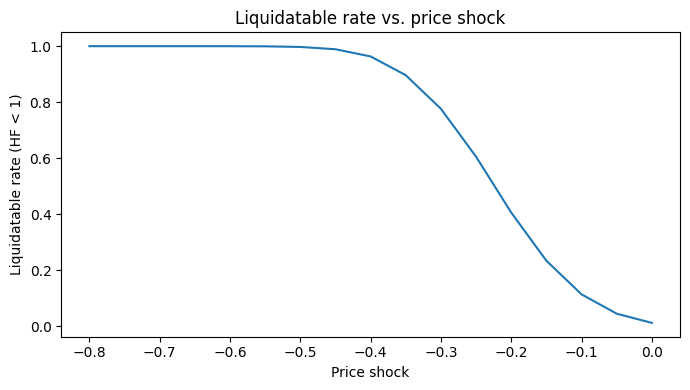

In [ ]:
#5. Plot the curve
plt.figure(figsize=(7, 4))
plt.plot(hf_curve["price_shock"], hf_curve["liquidatable_rate"])
plt.title("Liquidatable rate vs. price shock")
plt.xlabel("Price shock")
plt.ylabel("Liquidatable rate (HF < 1)")
plt.tight_layout()
#save
plt.savefig(FIG_DIR / "02_liquidatable_rate_curve.png", dpi=180, bbox_inches="tight")

plt.show()

In [ ]:
#6. Grid: (shock × delay) heatmap
rows = []
for shock in price_shocks:
    for delay in delay_levels:
      # Effective shock = market price shock + delay penalty (proxy for stale oracle / late execution)
      total_shock = shock + delay_to_extra_drop[delay]

      # Guardrail: avoid non-positive prices in extreme cases
      total_shock = shock + delay_to_extra_drop[delay]
      stressed_price = price_init * (1.0 + total_shock)

      # Compute HF under stressed price
      hf = compute_health_factor(
          collateral_amount=positions["collateral_amount"],
          debt_amount=positions["debt_amount"],
          price=stressed_price,
          liquidation_threshold=LIQUIDATION_THRESHOLD
      )

      # Share of positions that would be liquidatable (HF < 1)
      liquidatable_rate = (hf < 1.0).mean()

      # Store scenario result for later pivot/heatmap
      rows.append({
          "price_shock": shock,
          "delay_level": delay,
          "total_shock": total_shock,
          "stressed_price": stressed_price,
          "liquidatable_rate": liquidatable_rate
      })

hf_grid = pd.DataFrame(rows)
pivot_df = hf_grid.pivot(index="delay_level", columns="price_shock", values="liquidatable_rate")
pivot_df.iloc[:4, :6]

price_shock,-0.80,-0.75,-0.70,-0.65,-0.60,-0.55
delay_level,,,,,,
0,1.0,1.0,1.0,1.0,0.9999,0.9994
1,1.0,1.0,1.0,1.0,1.0000,0.9997
2,1.0,1.0,1.0,1.0,1.0000,0.9999
3,1.0,1.0,1.0,1.0,1.0000,1.0000


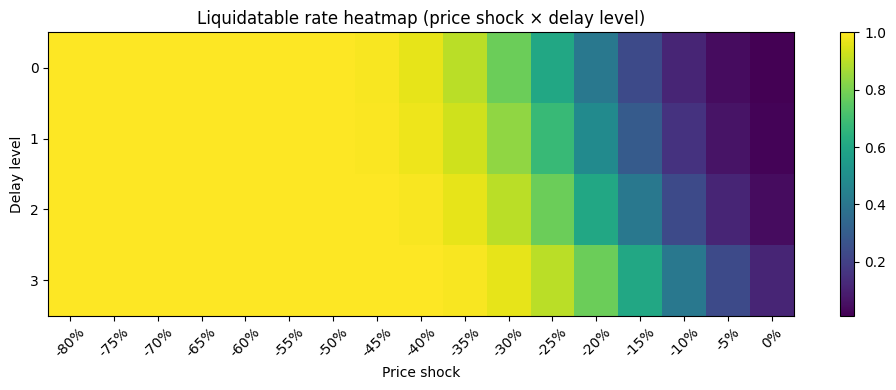

In [ ]:
#7. Plot heatmap
plt.figure(figsize=(10, 4))
plt.imshow(pivot_df.values, aspect="auto")
plt.title("Liquidatable rate heatmap (price shock × delay level)")
plt.xlabel("Price shock")
plt.ylabel("Delay level")

x_labels = [f"{c:.0%}" for c in pivot_df.columns]
plt.xticks(range(len(pivot_df.columns)), x_labels, rotation=45)
plt.yticks(range(len(pivot_df.index)), [str(i) for i in pivot_df.index])

plt.colorbar()
plt.tight_layout()
#save
plt.savefig(FIG_DIR / "02_liquidatable_rate_heatmap.png", dpi=180, bbox_inches="tight")
plt.show()